# Data Analysis

The whole data is available on the [https://feng.asymcatml.net/](https://feng.asymcatml.net/), you should download the data and the spliting data after confirming the data license.

In [10]:
"""
Author: TMJ
Date: 2025-03-10 22:08:00
LastEditors: TMJ
LastEditTime: 2025-04-15 23:47:08
Description: 请填写简介
"""

import itertools
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patchworklib as pw
import seaborn as sns
import torch
from matplotlib.colors import ListedColormap
from patchworklib.patchworklib import Bricks
from pycirclize import Circos
from rdkit import Chem
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import KFold

plt.rcParams["font.family"] = "Arial"
from dative_chemprop.utils import *

pw.overwrite_axisgrid()
torch.set_float32_matmul_precision("high")

chemprop_dir = Path.cwd()
input_path = Path.cwd() / "data" / "published_data.csv"
dataset = pd.read_csv(input_path, index_col=0)

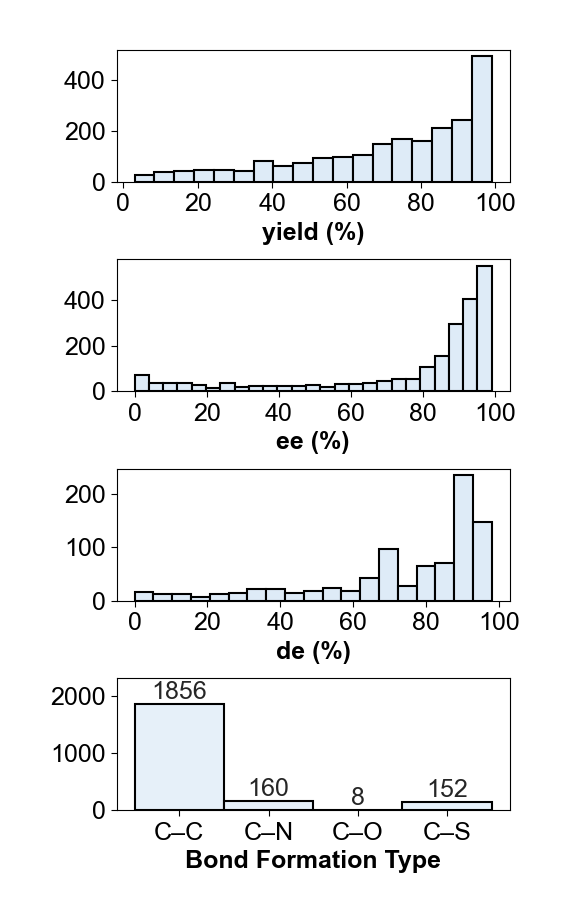

In [26]:
import matplotlib.pyplot as plt
from matplotlib.projections.polar import PolarAxes
from matplotlib.colors import ListedColormap


fig = plt.figure(figsize=(5, 10))
ax1 = plt.subplot2grid((10, 8), (0, 0), colspan=10, rowspan=2)
ax2 = plt.subplot2grid((10, 8), (2, 0), colspan=10, rowspan=2)
ax3 = plt.subplot2grid((10, 8), (4, 0), colspan=10, rowspan=2)
ax4 = plt.subplot2grid((10, 8), (6, 0), colspan=10, rowspan=2)
# ax4 = plt.subplot2grid((8, 10), (4, 0), colspan=5, rowspan=3)
# ax5 = plt.subplot2grid((8, 10), (4, 5), colspan=5, rowspan=3)
with sns.axes_style("ticks"):
    g1 = sns.histplot(
        dataset,
        x="yield (%)",
        ax=ax1,
        edgecolor="black",  # 设置边框颜色为黑色
        linewidth=1.5,
    )
    for i, bar in enumerate(g1.patches):
        bar.set_facecolor(color="#DEEBF7")
    g1.set_xlabel("yield (%)", fontdict={"size": 18, "fontweight": "bold"})
    g1.set_ylabel("")

with sns.axes_style("ticks"):
    g2 = sns.histplot(
        dataset,
        x="ee (%)",
        ax=ax2,
        edgecolor="black",
        linewidth=1.5,
    )
    for i, bar in enumerate(g2.patches):
        bar.set_facecolor(color="#DEEBF7")
    g2.set_xlabel("ee (%)", fontdict={"size": 18, "fontweight": "bold"})
    g2.set_ylabel("")

with sns.axes_style("ticks"):
    g3 = sns.histplot(
        dataset,
        x="de (%)",
        ax=ax3,
        edgecolor="black",
        linewidth=1.5,
    )
    for i, bar in enumerate(g3.patches):
        bar.set_facecolor(color="#DEEBF7")
    g3.set_xlabel("de (%)", fontdict={"size": 18, "fontweight": "bold"})
    g3.set_ylabel("")
with sns.axes_style("ticks"):
    g4 = sns.histplot(
        dataset,
        x="Michael Bonding Type",
        edgecolor="black",
        linewidth=1.5,
        color="#DEEBF7",
    )
    g4.set_ylim(0, 2300)
    g4.bar_label(g4.containers[0], fmt="%.0f", fontsize=18)
    g4.set_ylabel("")
    g4.set_xticklabels(["C–C", "C–N", "C–O", "C–S"])
    g4.set_xlabel("Bond Formation Type", fontdict={"size": 18, "fontweight": "bold"})

for label in (
    ax1.get_xticklabels()
    + ax2.get_xticklabels()
    + ax3.get_xticklabels()
    + ax4.get_xticklabels()
    + ax1.get_yticklabels()
    + ax2.get_yticklabels()
    + ax3.get_yticklabels()
    + ax4.get_yticklabels()
):
    label.set_fontsize(18)
# 调整布局以避免重叠
plt.tight_layout()
plt.savefig("img/1D-distribution.png", dpi=300)
# 显示图形
plt.show()

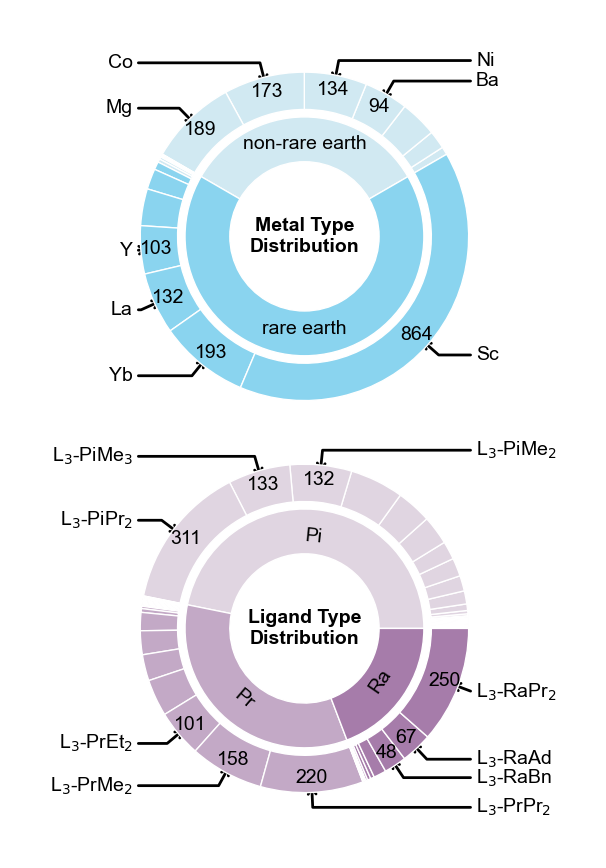

In [12]:
fig = plt.figure(figsize=(10, 8))
ax3 = plt.subplot2grid((8, 8), (0, 0), colspan=4, rowspan=4)
ax4 = plt.subplot2grid((8, 8), (4, 0), colspan=4, rowspan=4)
# ax5 = plt.subplot2grid((8, 8), (0, 4), colspan=4, rowspan=4)


def draw_sunburst(
    ax: plt.Axes,
    dataset: pd.DataFrame,
    class_name: str,
    sub_class_name: str,
    cmap,
    title: str = "",
    topk: int = 3,
    threshold_col_name: str = "ee (%)",
    threshold: float = 80.0,
    startangle: float = 90,
) -> None:
    recipe = dataset.value_counts(class_name).sort_index().index
    data = dataset.value_counts(class_name).sort_index().values
    colors = ListedColormap(cmap)(np.arange(len(data)) / len(data))
    wedges, texts = ax.pie(
        data,
        labels=None,
        colors=colors,
        radius=0.8,
        wedgeprops=dict(width=0.3, edgecolor="w", lw=1),
        startangle=startangle,
    )
    for i, w in enumerate(wedges):
        ang = (w.theta2 - w.theta1) / 2.0 + w.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        ax.text(
            0.62 * x,
            0.62 * y,
            recipe[i],
            ha="center",
            va="center",
            size=14,
            rotation=ang + 90 if ang % 360 > 180 else ang - 90,
        )
    dfs = []
    for i, subdf in dataset.groupby([class_name, sub_class_name]):
        dfs.append(
            pd.DataFrame(
                {
                    "count": [subdf.shape[0]],
                    "optimal": [(subdf[threshold_col_name] > threshold).sum()],
                    sub_class_name: [subdf[sub_class_name].iloc[0]],
                    class_name: [subdf[class_name].iloc[0]],
                }
            )
        )
    count_df = pd.concat(dfs).sort_values([class_name, "count"]).reset_index(drop=True)
    if_annotate = []
    for i, subdf in count_df.groupby(class_name):
        if_annotate.extend((subdf["count"].rank(ascending=False) <= topk).to_list())
    sub_recipes = count_df[sub_class_name].values
    sub_data = count_df["count"].values
    optimal_data = []
    for count, optimal in zip(count_df["count"], count_df["optimal"]):
        optimal_data.extend((count - optimal, optimal))

    optimal_ratio = [
        optimal / count
        for count, optimal in zip(count_df["count"], count_df["optimal"])
    ]
    sub_colors = np.concatenate(
        [
            colors[i].reshape(1, -1).repeat(c, axis=0)
            for i, c in enumerate(count_df.value_counts(class_name))
        ]
    )
    sub_wedges, sub_texts = ax.pie(
        sub_data,
        colors=sub_colors,
        radius=1.1,
        wedgeprops=dict(width=0.25, edgecolor="w", lw=1),
        startangle=startangle,
    )
    kw = dict(arrowprops=dict(arrowstyle="->", lw=2), zorder=0, va="center")
    for i, p in enumerate(sub_wedges):
        if sub_data[i] < 30 or not if_annotate[i]:
            continue
        ang = (p.theta2 - p.theta1) / 2.0 + p.theta1
        y = np.sin(np.deg2rad(ang))
        x = np.cos(np.deg2rad(ang))
        ax.text(
            x,
            y,
            f"{sub_data[i]}",
            ha="center",
            va="center",
            fontdict={"color": "black", "size": 14},
        )
        horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
        connectionstyle = f"angle,angleA=0,angleB={ang}"
        kw["arrowprops"].update({"connectionstyle": connectionstyle})
        ax.annotate(
            f"{sub_recipes[i]}",
            xy=(1.02 * x, 1.02 * y),
            xytext=(1.15 * np.sign(x), 1.2 * y),
            horizontalalignment=horizontalalignment,
            size=14,
            **kw,
        )
    ax.text(
        0.5,
        0.5,
        title,
        horizontalalignment="center",
        verticalalignment="center",
        fontdict={"size": 14, "fontweight": "bold"},
        transform=ax.transAxes,
    )


draw_sunburst(
    ax3,
    dataset=dataset,
    class_name="is_rare_earth",
    sub_class_name="Metal",
    cmap=sns.light_palette("#44c0ed", n_colors=30, input="hex")[5:],
    startangle=30,
    topk=4,
    title="Metal Type\nDistribution",
)

draw_sunburst(
    ax4,
    dataset=dataset,
    class_name="ligand_type",
    sub_class_name="Ligand Name",
    cmap=sns.light_palette("#8a508f", n_colors=30, input="hex")[5:],
    startangle=0,
    title="Ligand Type\nDistribution",
)


# 调整布局以避免重叠
plt.tight_layout()
plt.savefig("img/1D-distribution-2.png", dpi=300)
# 显示图形
plt.show()

In [4]:
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole

acceptors = dataset.value_counts(["Ligand Name", "ligands_smiles"]).reset_index()
mols = [Chem.MolFromSmiles(smiles) for smiles in acceptors["ligands_smiles"]]
for mol in mols:
    AllChem.Compute2DCoords(mol)
Draw.SetACS1996Mode(IPythonConsole.drawOptions, Draw.MeanBondLength(mols[0]))
opts = IPythonConsole.drawOptions
opts.legendFraction = 0.15
opts.legendFontSize = 18
ligand_legends = [
    f"{name.replace('$_','<sub>').replace('$','</sub>')}\ncount: {count}"
    for name, count in zip(acceptors["Ligand Name"], acceptors["count"])
]

g1 = Draw.MolsToGridImage(
    mols[:20],
    legends=ligand_legends[:20],
    molsPerRow=4,
    subImgSize=(225, 175),
    useSVG=True,
    drawOptions=opts,
)
with open("img/ligands_1.svg", "w") as f:
    f.write(g1.data)
g1 = Draw.MolsToGridImage(
    mols[20:48],
    legends=ligand_legends[20:48],
    molsPerRow=4,
    subImgSize=(225, 175),
    useSVG=True,
)
with open("img/ligands_2.svg", "w") as f:
    f.write(g1.data)
g1 = Draw.MolsToGridImage(
    mols[48:],
    legends=ligand_legends[48:],
    molsPerRow=4,
    subImgSize=(250, 175),
    useSVG=True,
)
with open("img/ligands_3.svg", "w") as f:
    f.write(g1.data)

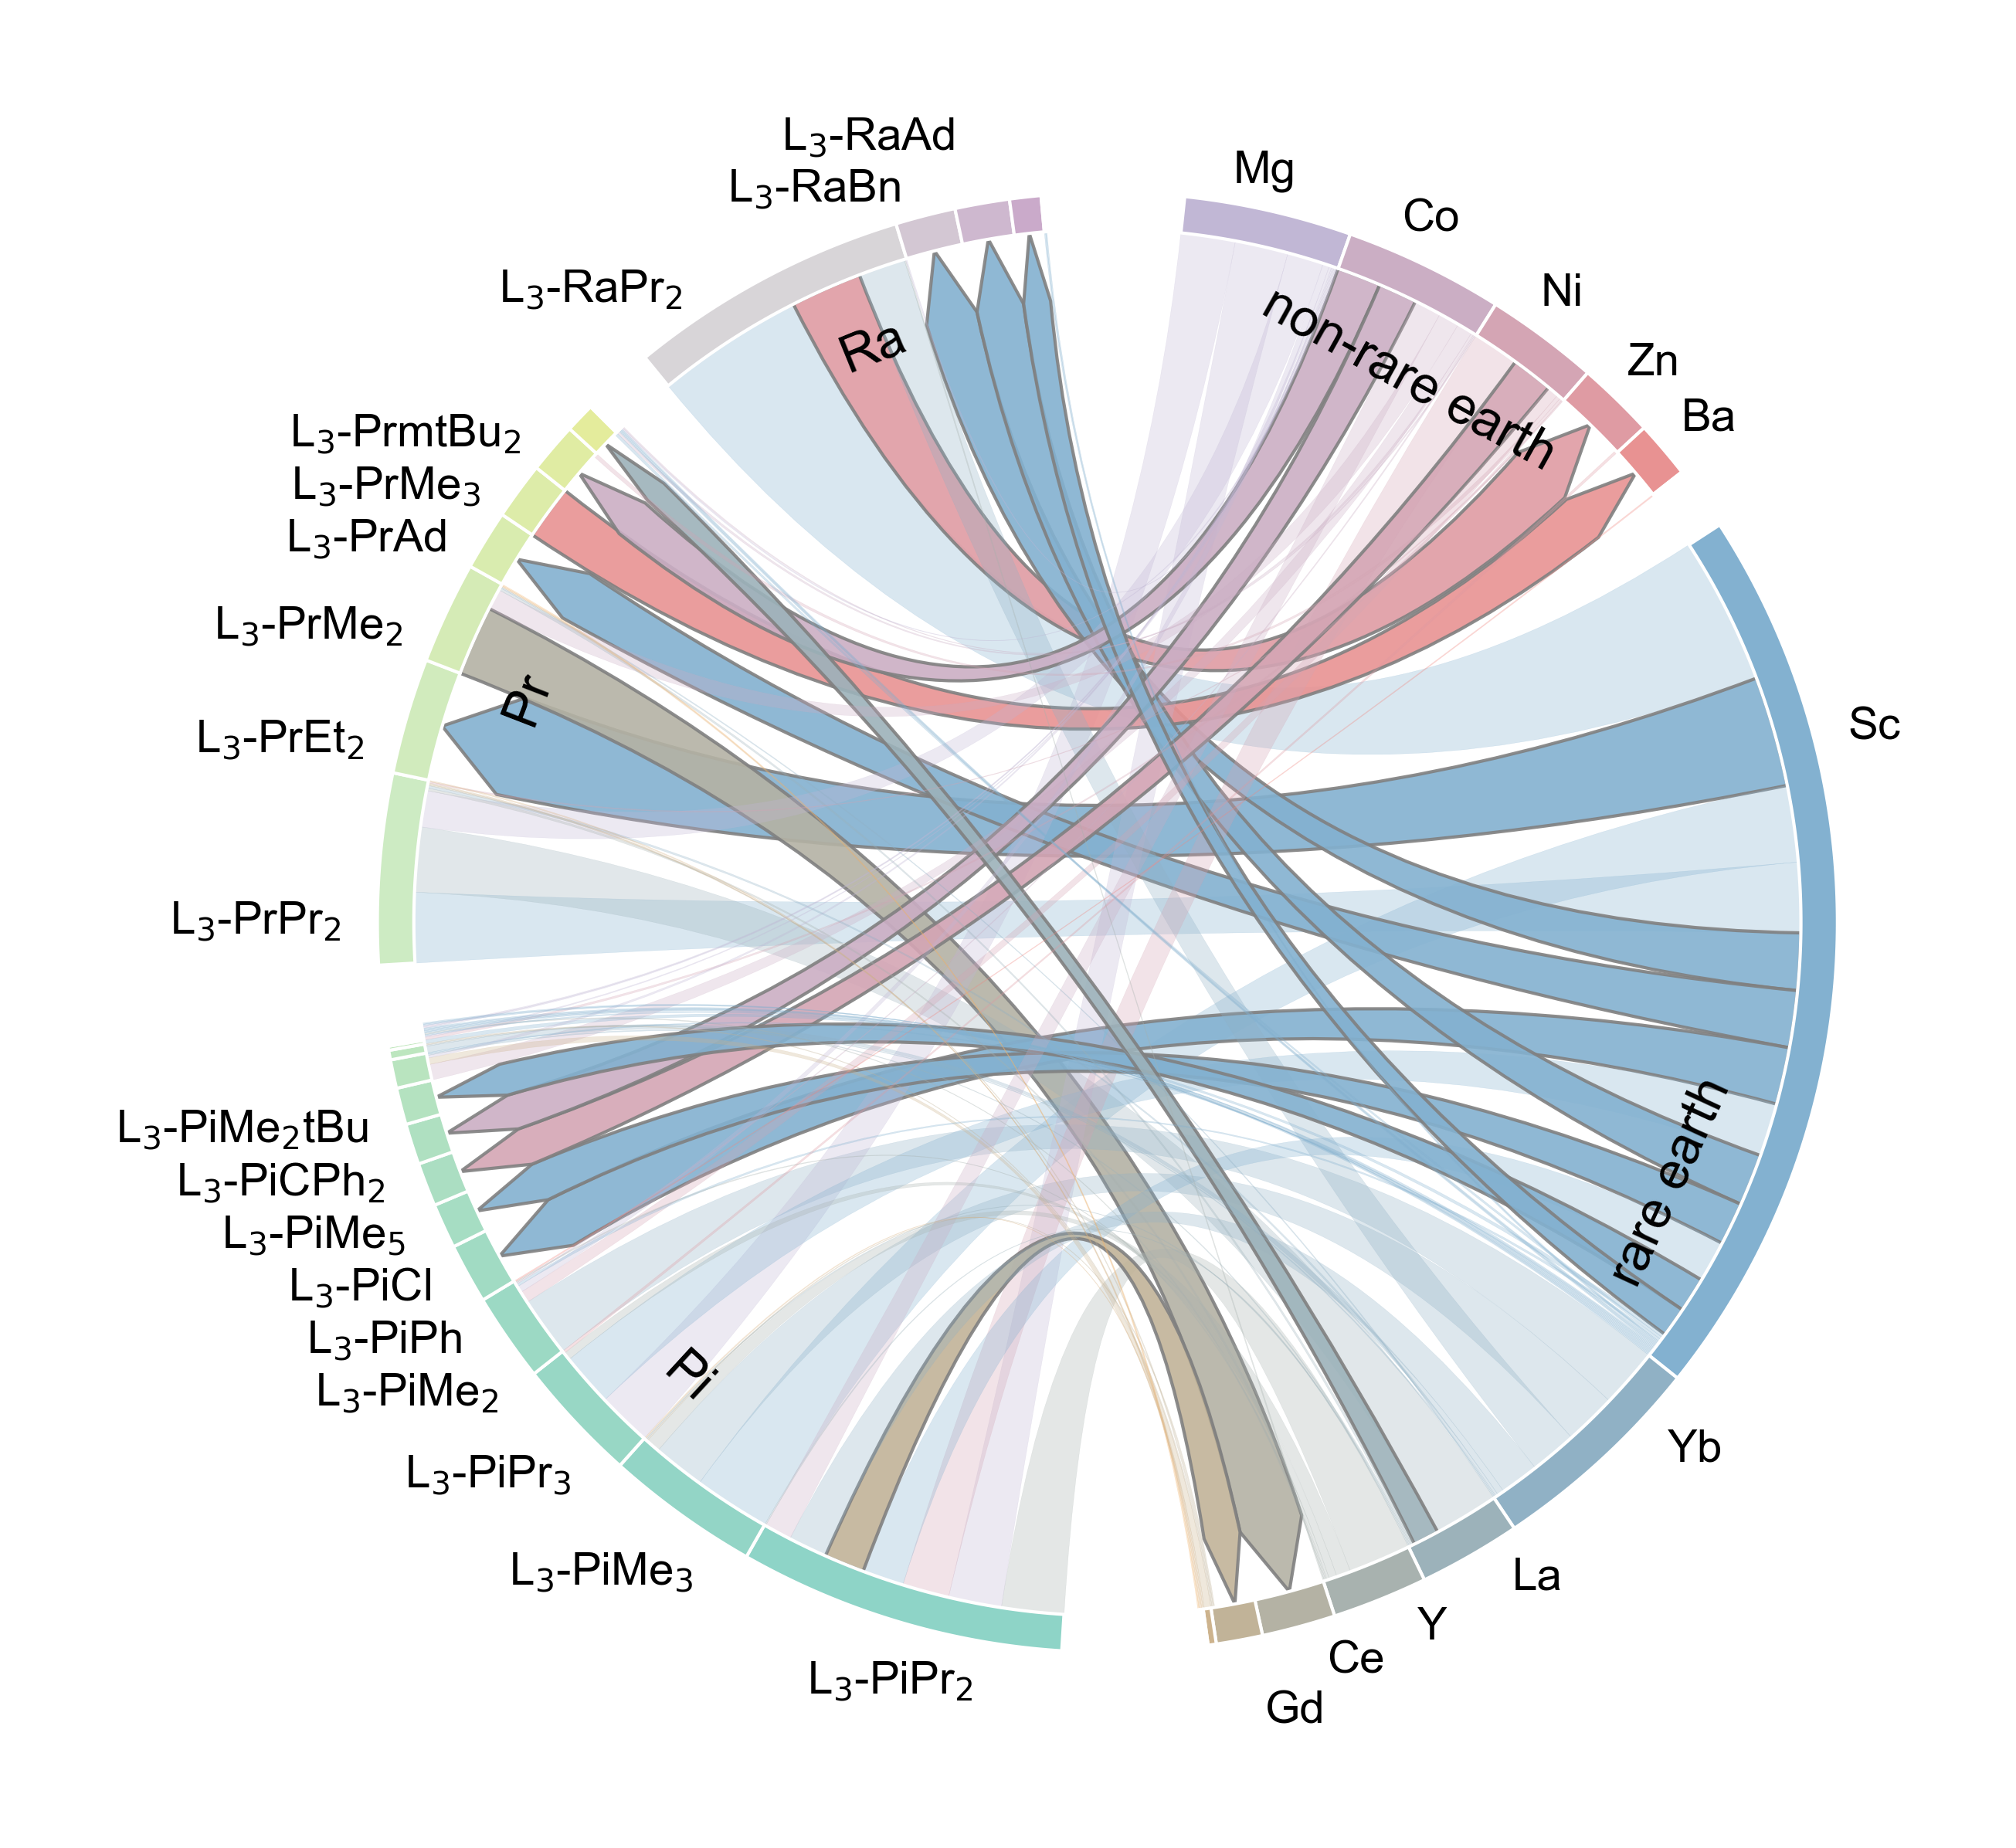

In [5]:
from pycirclize import Circos

tempd = dataset.copy()
background_data = tempd.loc[tempd["ee (%)"] > 80]
background_data["Ligand Type"] = background_data["ligand_type"]
background_data["Metal Type"] = background_data["is_rare_earth"]
d = background_data.copy()


sectors = {
    "  ": 10,
    **{k: v for k, v in d.value_counts("Metal Type").sort_index().to_dict().items()},
    " ": 10,
    **{k: v for k, v in d.value_counts("Ligand Type").sort_index().to_dict().items()},
}

nodes = {
    " ": {" ": (10, "")},
    **{
        key: {
            k: (v, k)
            for k, v in d.loc[d["Metal Type"] == key]
            .value_counts("Metal")
            .sort_values(ascending=False)
            .to_dict()
            .items()
        }
        for key in d.value_counts("Metal Type").sort_index().to_dict().keys()
    },
    "  ": {"  ": (10, "")},
    **{
        key: {
            k: (v, k)
            for k, v in d.loc[d["Ligand Type"] == key]
            .value_counts("Ligand Name")
            .sort_values(ascending=False)
            .to_dict()
            .items()
        }
        for key in d.value_counts("Ligand Type").sort_values().to_dict().keys()
    },
}
colors = {
    sec: {
        node: color
        for node, color in zip(
            nodes[sec].keys(),
            sns.blend_palette(
                [color_start, color_end], n_colors=len(nodes[sec]) * 10 + 3
            )[3:-1:10],
        )
    }
    for (color_start, color_end), sec in zip(
        np.array(sns.color_palette("Set3", n_colors=len(nodes) * 2)).reshape(
            len(nodes), 2, -1
        ),
        nodes,
    )
}
colors.update(
    {
        "  ": {"  ": [1, 1, 1]},
        " ": {" ": [1, 1, 1]},
    }
)
mapping = {}
circos = Circos(sectors=sectors, space=5, start=0, end=360)
for sector in circos.sectors:
    track = sector.add_track((95, 100), r_pad_ratio=0.5)
    # track.rect(0, sector.end, lw=1, ec="white")
    track.text(sector.name, r=85, fontsize=16)

    start, end = 0, 0
    for (node, (value, label)), color in zip(
        nodes[sector.name].items(), colors[sector.name].values()
    ):
        end += value
        if value > 25:
            track.annotate(
                3 / 4 * start + 1 / 4 * end,
                label,
                label_size=14,
                shorten=50,
                min_r=100,
                line_kws=dict(lw=0),
            )
        sector.rect(start, end, r_lim=(95, 100), lw=1, ec="white", color=color)
        mapping[node] = {
            "sector": sector.name,
            "start": start,
            "end": end,
            "max_end": start,
        }
        start = end
colors = {
    node: color for color_seq in colors.values() for node, color in color_seq.items()
}

for idx, row in d.value_counts(["Metal", "Ligand Name"]).reset_index().iterrows():
    metal_name, lig_name = (row["Metal"], row["Ligand Name"])
    value = row["count"]
    if metal_name in mapping[lig_name]:
        metal_start, metal_end = mapping[lig_name][metal_name]
    else:
        metal_start, metal_end = (
            mapping[lig_name]["max_end"],
            mapping[lig_name]["max_end"] + value,
        )
        mapping[lig_name][metal_name] = (metal_start, metal_end)
        mapping[lig_name]["max_end"] = metal_end
    if lig_name in mapping[metal_name]:
        lig_start, lig_end = mapping[metal_name][lig_name]
    else:
        lig_start, lig_end = (
            mapping[metal_name]["max_end"],
            mapping[metal_name]["max_end"] + value,
        )
        mapping[metal_name][lig_name] = (lig_start, lig_end)
        mapping[metal_name]["max_end"] = lig_end
    if (
        value > (mapping[metal_name]["end"] - mapping[metal_name]["start"]) * 0.9
    ) and value > 10:
        circos.link(
            (mapping[lig_name]["sector"], metal_end, metal_start),
            (mapping[metal_name]["sector"], lig_start, lig_end),
            r1=95,
            r2=95,
            direction=1,
            arrow_length_ratio=0.1,
            alpha=0.9,
            ec="grey",
            lw=1,
            color=colors[metal_name],
        )
    elif (
        value > (mapping[lig_name]["end"] - mapping[lig_name]["start"]) * 0.9
        and value > 10
    ):
        circos.link(
            (mapping[metal_name]["sector"], lig_start, lig_end),
            (mapping[lig_name]["sector"], metal_end, metal_start),
            r1=95,
            r2=95,
            direction=1,
            arrow_length_ratio=0.1,
            alpha=0.9,
            ec="grey",
            lw=1,
            color=colors[metal_name],
        )
    else:
        circos.link(
            (mapping[metal_name]["sector"], lig_start, lig_end),
            (mapping[lig_name]["sector"], metal_end, metal_start),
            r1=95,
            r2=95,
            direction=0,
            arrow_length_ratio=0.1,
            alpha=0.3,
            color=colors[metal_name],
        )
fig = circos.plotfig(dpi=300)
fig.savefig("img/metal_ligand_coupling.png")
fig.show()

In [6]:
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole

acceptors = (
    dataset.value_counts(["acceptor_indice", "acceptor_smiles"])
    .reset_index()
    .sort_values("acceptor_indice")
)
mols = [Chem.MolFromSmiles(smiles) for smiles in acceptors["acceptor_smiles"]]
for mol in mols:
    AllChem.Compute2DCoords(mol)
Draw.SetACS1996Mode(IPythonConsole.drawOptions, Draw.MeanBondLength(mols[0]))
opts = IPythonConsole.drawOptions
opts.legendFraction = 0.2
opts.legendFontSize = 18
legends = [
    f"indice: {indice:.4f}\ncount: {count}"
    for indice, count in zip(acceptors["acceptor_indice"], acceptors["count"])
]

g1 = Draw.MolsToGridImage(
    mols,
    legends=legends,
    molsPerRow=15,
    subImgSize=(150, 150),
    useSVG=True,
    drawOptions=opts,
    maxMols=500,
)
with open("img/acceptors.svg", "w") as f:
    f.write(g1.data)

donors = (
    dataset.value_counts(["donor_indice", "donor_smiles"])
    .reset_index()
    .sort_values("donor_indice")
)

mols = [Chem.MolFromSmiles(smiles) for smiles in donors["donor_smiles"]]
legends = [
    f"indice: {indice:.4f}\ncount: {count}"
    for indice, count in zip(donors["donor_indice"], donors["count"])
]

g1 = Draw.MolsToGridImage(
    mols,
    legends=legends,
    molsPerRow=15,
    subImgSize=(150, 150),
    useSVG=True,
    drawOptions=opts,
    maxMols=500,
)
with open("img/donors.svg", "w") as f:
    f.write(g1.data)

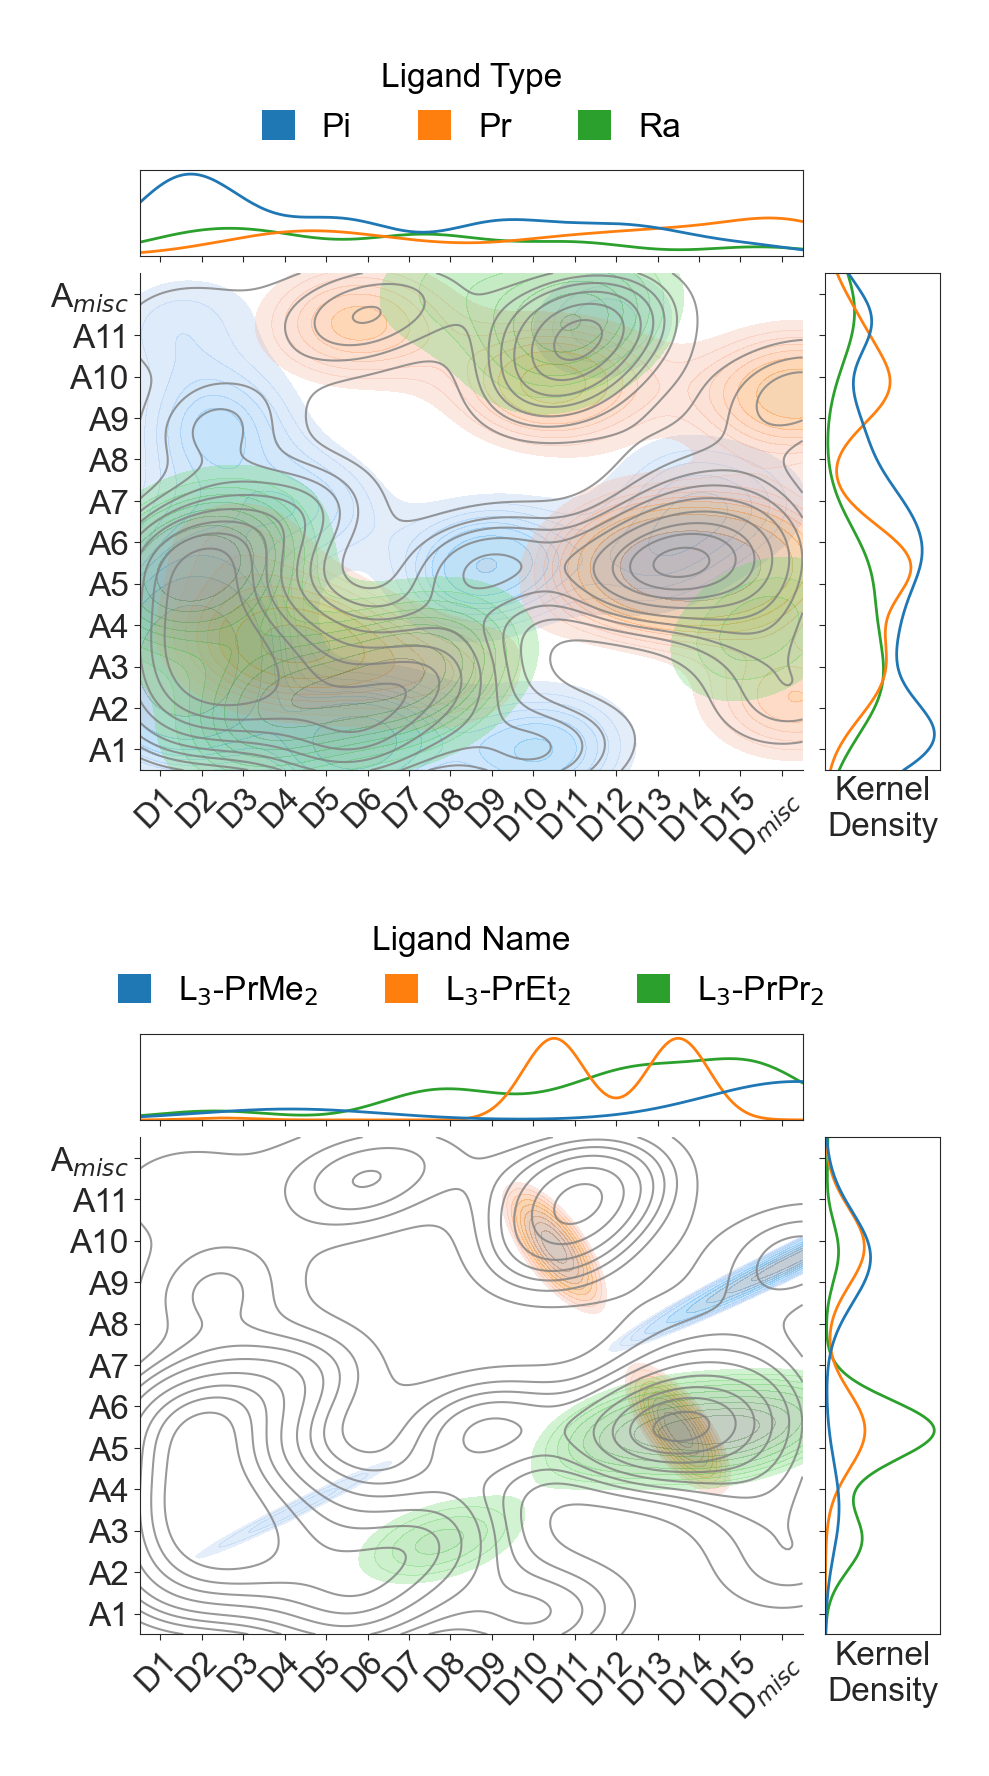

In [21]:
from seaborn import JointGrid

background_data.rename(
    columns={
        "Metal": "Metal Salt",
        "Metal Type": "Metal Salt Type",
    },
    inplace=True,
)


def build_overlap(
    df: pd.DataFrame,
    hue_name: str,
    background_df: pd.DataFrame | None = None,
    set_xticks=True,
    set_yticks=True,
    thresh=0.2,
    font_size=24,
    palette=None,
) -> JointGrid:
    with sns.axes_style("ticks"):
        g = sns.JointGrid(
            data=df,
            y="acceptor_indice",
            x="donor_indice",
            hue=hue_name,
            marginal_ticks=True,
        )
        if isinstance(background_df, pd.DataFrame):
            sns.kdeplot(
                data=background_df,
                x="donor_indice",
                y="acceptor_indice",
                fill=False,
                common_norm=False,
                alpha=0.8,
                levels=10,
                color="gray",
                linewidths=1.5,
                ax=g.ax_joint,
                clip=(
                    (0, len(donor_templates_mapping)),
                    (0, len(acceptor_templates_mapping)),
                ),
            )
        g.plot_joint(
            sns.kdeplot,
            fill=True,
            common_norm=False,
            levels=10,
            alpha=0.3,
            thresh=thresh,
            palette=palette,
            clip=(
                (0, len(donor_templates_mapping)),
                (0, len(acceptor_templates_mapping)),
            ),
        )
        sns.kdeplot(
            data=df,
            x="donor_indice",
            hue=hue_name,
            common_norm=True,
            common_grid=True,
            legend=False,
            palette=palette,
            linewidth=2,
            ax=g.ax_marg_x,
            clip=(0, len(donor_templates_mapping)),
        )
        sns.kdeplot(
            data=df,
            y="acceptor_indice",
            hue=hue_name,
            common_norm=True,
            common_grid=True,
            legend=False,
            palette=palette,
            linewidth=2,
            ax=g.ax_marg_y,
            clip=(0, len(acceptor_templates_mapping)),
        )
        g.ax_joint.set_ylim((0, len(acceptor_templates_mapping)))
        g.ax_joint.set_xlim((0, len(donor_templates_mapping)))
        g.ax_joint.set_yticks([t + 0.5 for t in get_ticks(acceptor_templates_mapping)])
        g.ax_joint.set_xticks([t + 0.5 for t in get_ticks(donor_templates_mapping)])
        g.ax_marg_x.set_yticks([])
        g.ax_marg_y.set_xticks([])
        for label in g.ax_marg_x.get_yticklabels():
            label.set_fontsize(font_size)
        for label in g.ax_marg_y.get_xticklabels():
            label.set_fontsize(font_size)
        g.ax_marg_x.set_ylabel("", fontdict=dict(fontsize=font_size))
        g.ax_marg_y.set_xlabel("Kernel\nDensity", fontdict=dict(fontsize=font_size))
        if set_xticks:
            g.ax_joint.set_xticklabels(
                [v["code_name"] for v in list(donor_templates_mapping.values())[:-1]]
                + ["D$_{misc}$"],
                rotation=45,
                rotation_mode="anchor",
                fontdict=dict(fontsize=font_size),
            )
        else:
            g.ax_joint.set_xticklabels([])
        for label in g.ax_joint.get_xticklabels():
            label.set_horizontalalignment("right")
        if set_yticks:
            g.ax_joint.set_yticklabels(
                [v["code_name"] for v in list(acceptor_templates_mapping.values())[:-1]]
                + ["A$_{misc}$"],
                fontdict=dict(fontsize=font_size),
            )
        else:
            g.ax_joint.set_yticklabels([])
        g.ax_joint.set_xlabel("")
        g.ax_joint.set_ylabel("")
    sns.move_legend(
        g.ax_joint,
        "lower center",
        bbox_to_anchor=(0.5, 1.2),
        ncol=6,
        fontsize=font_size,
        title_fontsize=font_size,
    )
    return g


g2 = build_overlap(
    background_data,
    "Ligand Type",
    background_data,
    # set_xticks=False,
    # set_yticks=False,
    thresh=0.15,
)
g3 = build_overlap(
    background_data.loc[
        background_data["Ligand Name"].isin(
            ["L$_3$-PrMe$_2$", "L$_3$-PrEt$_2$", "L$_3$-PrPr$_2$"]
        )
    ].sort_values(
        "Ligand Name",
        key=lambda x: x.map(
            {"L$_3$-PrMe$_2$": 0, "L$_3$-PrEt$_2$": 1, "L$_3$-PrPr$_2$": 2}
        ),
    ),
    "Ligand Name",
    background_data,
    # set_yticks=False,
    thresh=0.35,
)
b2 = pw.load_seaborngrid(g2, figsize=(8, 6))
b3 = pw.load_seaborngrid(g3, figsize=(8, 6))
(b2 / b3).savefig("img/ligand_overlap.png", dpi=300, bbox_inches="tight")

In [22]:
background_data

yield (%)  ddG (kcal/mol)  ee (%)  dr  de (%)  \
0          75.0        2.768043      98 NaN     NaN   
1          63.0        3.188620      99 NaN     NaN   
2          52.0        2.768043      98 NaN     NaN   
3          72.0        3.188620      99 NaN     NaN   
4          82.0        1.713101      89 NaN     NaN   
...         ...             ...     ...  ..     ...   
2164       80.0        1.394145      87 NaN     NaN   
2165       82.0        1.487061      89 NaN     NaN   
2166       45.0        1.277112      84 NaN     NaN   
2172       70.0        1.209808      82 NaN     NaN   
2173       45.0        1.277112      84 NaN     NaN   

                 acceptor_smiles         donor_smiles     donor_active_smiles  \
0     CCOC(=O)/C=C/C(=O)c1ccccc1  COC(=O)C(C(=O)OC)Cl  COC(=O)C(Cl)=C([O-])OC   
1     CCOC(=O)/C=C/C(=O)c1ccccc1  COC(=O)C(C(=O)OC)Cl  COC(=O)C(Cl)=C([O-])OC   
2     CCOC(=O)/C=C/C(=O)c1ccccc1  COC(=O)C(C(=O)OC)Cl  COC(=O)C(Cl)=C([O-])OC   
3     CCOC(=O)/C=C/C(=O)c1ccccc1  COC(=O)C(C(=O)OC)Cl  COC(=O)C(Cl)=C([O-])OC   
4     CCOC(=O)/C=C/C(=O)c1ccccc1  COC(=O)C(C(=O)OC)Cl  COC(=O)C(Cl)=C([O-])OC   
...                          ...                  ...                     ...   
2164        CCc1ccc2c(c1)occc2=O       N#C[Si](C)(C)C                  [C-]#N   
2165     CC(c1ccc2c(c1)occc2=O)C       N#C[Si](C)(C)C                  [C-]#N   
2166       Fc1ccc2c(c1)c(=O)cco2       N#C[Si](C)(C)C                  [C-]#N   
2172      O=c1ccoc2c1cc1ccccc1c2       N#C[Si](C)(C)C                  [C-]#N   
2173      O=c1ccoc2c1ccc1c2cccc1       N#C[Si](C)(C)C                  [C-]#N   

                            reactants_couples_smiles  \
0     CCOC(=O)/C=C/C(=O)c1ccccc1.COC(=O)C(C(=O)OC)Cl   
1     CCOC(=O)/C=C/C(=O)c1ccccc1.COC(=O)C(C(=O)OC)Cl   
2     CCOC(=O)/C=C/C(=O)c1ccccc1.COC(=O)C(C(=O)OC)Cl   
3     CCOC(=O)/C=C/C(=O)c1ccccc1.COC(=O)C(C(=O)OC)Cl   
4     CCOC(=O)/C=C/C(=O)c1ccccc1.COC(=O)C(C(=O)OC)Cl   
...                                              ...   
2164             CCc1ccc2c(c1)occc2=O.N#C[Si](C)(C)C   
2165          CC(c1ccc2c(c1)occc2=O)C.N#C[Si](C)(C)C   
2166            Fc1ccc2c(c1)c(=O)cco2.N#C[Si](C)(C)C   
2172           O=c1ccoc2c1cc1ccccc1c2.N#C[Si](C)(C)C   
2173           O=c1ccoc2c1ccc1c2cccc1.N#C[Si](C)(C)C   

                        reactants_active_couples_smiles  ... donor_class_code  \
0     CCOC(=O)/C=C/C(=O)c1ccccc1.COC(=O)C(Cl)=C([O-])OC  ...               D1   
1     CCOC(=O)/C=C/C(=O)c1ccccc1.COC(=O)C(Cl)=C([O-])OC  ...               D1   
2     CCOC(=O)/C=C/C(=O)c1ccccc1.COC(=O)C(Cl)=C([O-])OC  ...               D1   
3     CCOC(=O)/C=C/C(=O)c1ccccc1.COC(=O)C(Cl)=C([O-])OC  ...               D1   
4     CCOC(=O)/C=C/C(=O)c1ccccc1.COC(=O)C(Cl)=C([O-])OC  ...               D1   
...                                                 ...  ...              ...   
2164                        CCc1ccc2c(c1)occc2=O.[C-]#N  ...         D-Others   
2165                     CC(c1ccc2c(c1)occc2=O)C.[C-]#N  ...         D-Others   
2166                       Fc1ccc2c(c1)c(=O)cco2.[C-]#N  ...         D-Others   
2172                      O=c1ccoc2c1cc1ccccc1c2.[C-]#N  ...         D-Others   
2173                      O=c1ccoc2c1ccc1c2cccc1.[C-]#N  ...         D-Others   

     donor_subclass     acceptor_subclass donor_subgroup acceptor_subgroup  \
0       Bidentate-1           Bidentate-1      Bidentate         Bidentate   
1       Bidentate-1           Bidentate-1      Bidentate         Bidentate   
2       Bidentate-1           Bidentate-1      Bidentate         Bidentate   
3       Bidentate-1           Bidentate-1      Bidentate         Bidentate   
4       Bidentate-1           Bidentate-1      Bidentate         Bidentate   
...             ...                   ...            ...               ...   
2164         Others  Monodentate-cyclic-2         Others       Monodentate   
2165         Others  Monodentate-cyclic-2         Others       Monodentate   
2166         Others  Mon

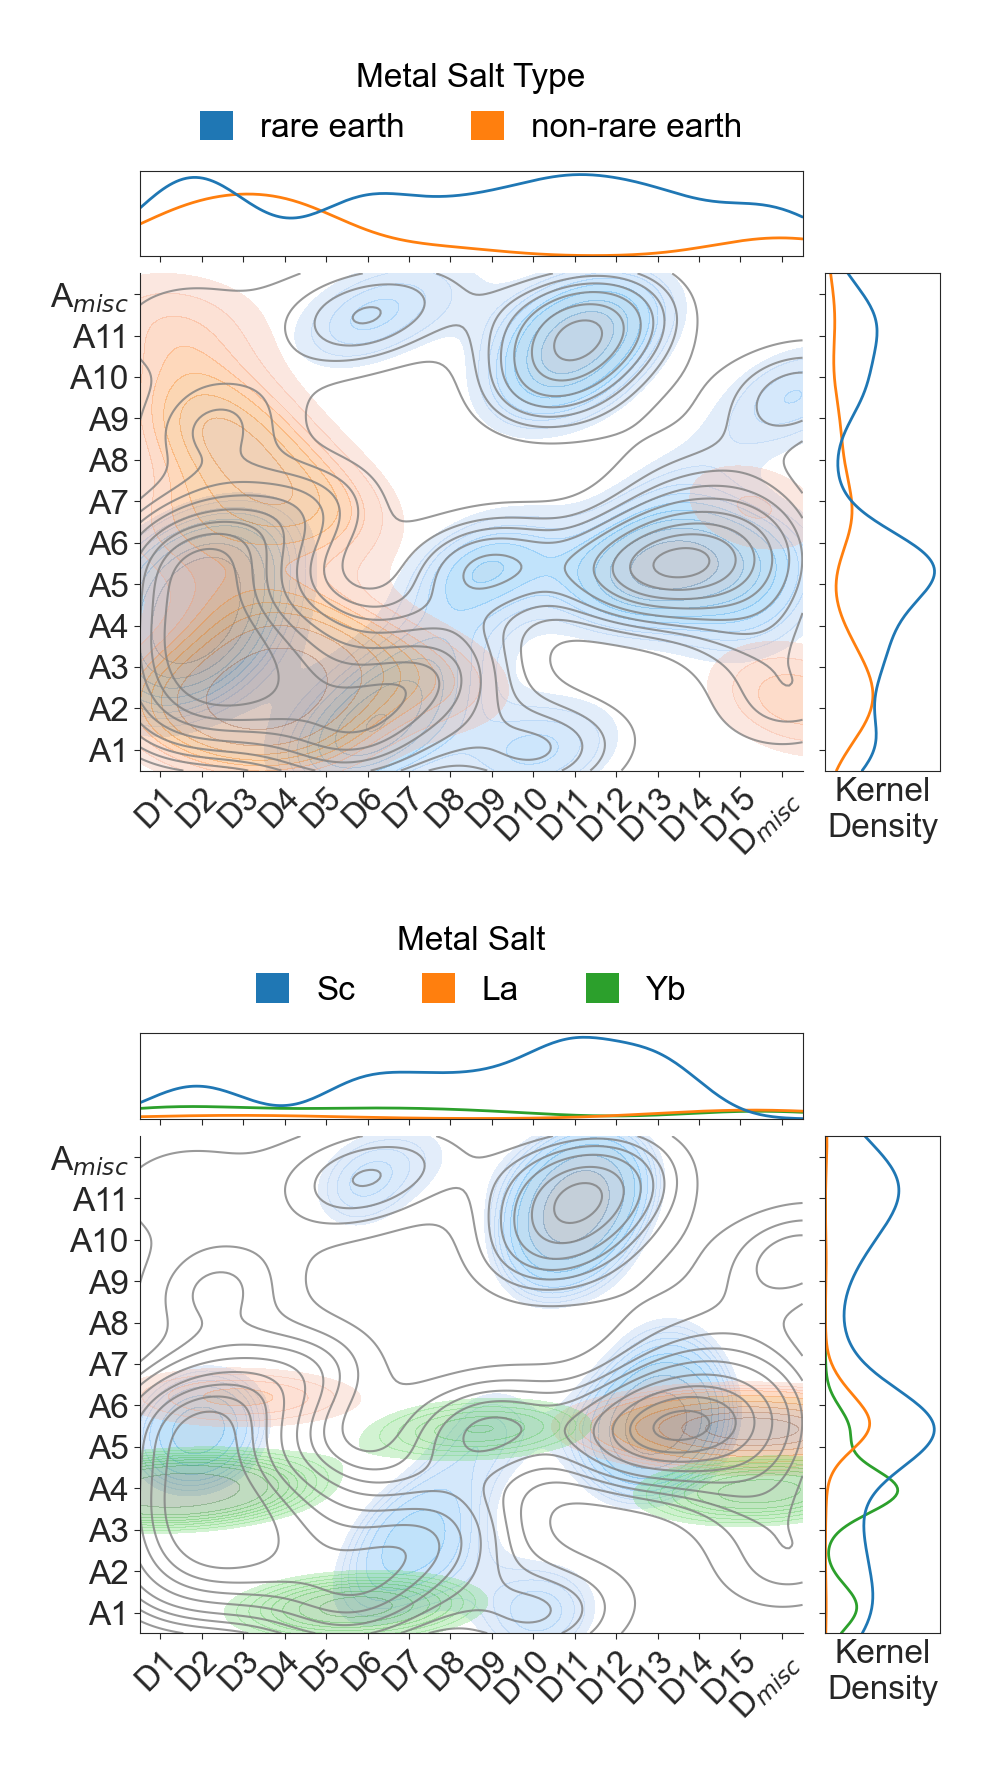

In [24]:
g4 = build_overlap(
    background_data,
    "Metal Salt Type",
    background_data,
    # set_xticks=False,
    thresh=0.15,
)

g5 = build_overlap(
    background_data.loc[background_data["Metal Salt"].isin(["Sc", "La", "Yb"])],
    "Metal Salt",
    background_data,
    thresh=0.32,
)
b4 = pw.load_seaborngrid(g4, figsize=(8, 6))
b5 = pw.load_seaborngrid(g5, figsize=(8, 6))
(b4 / b5).savefig("img/metal_overlap.png", dpi=300, bbox_inches="tight")

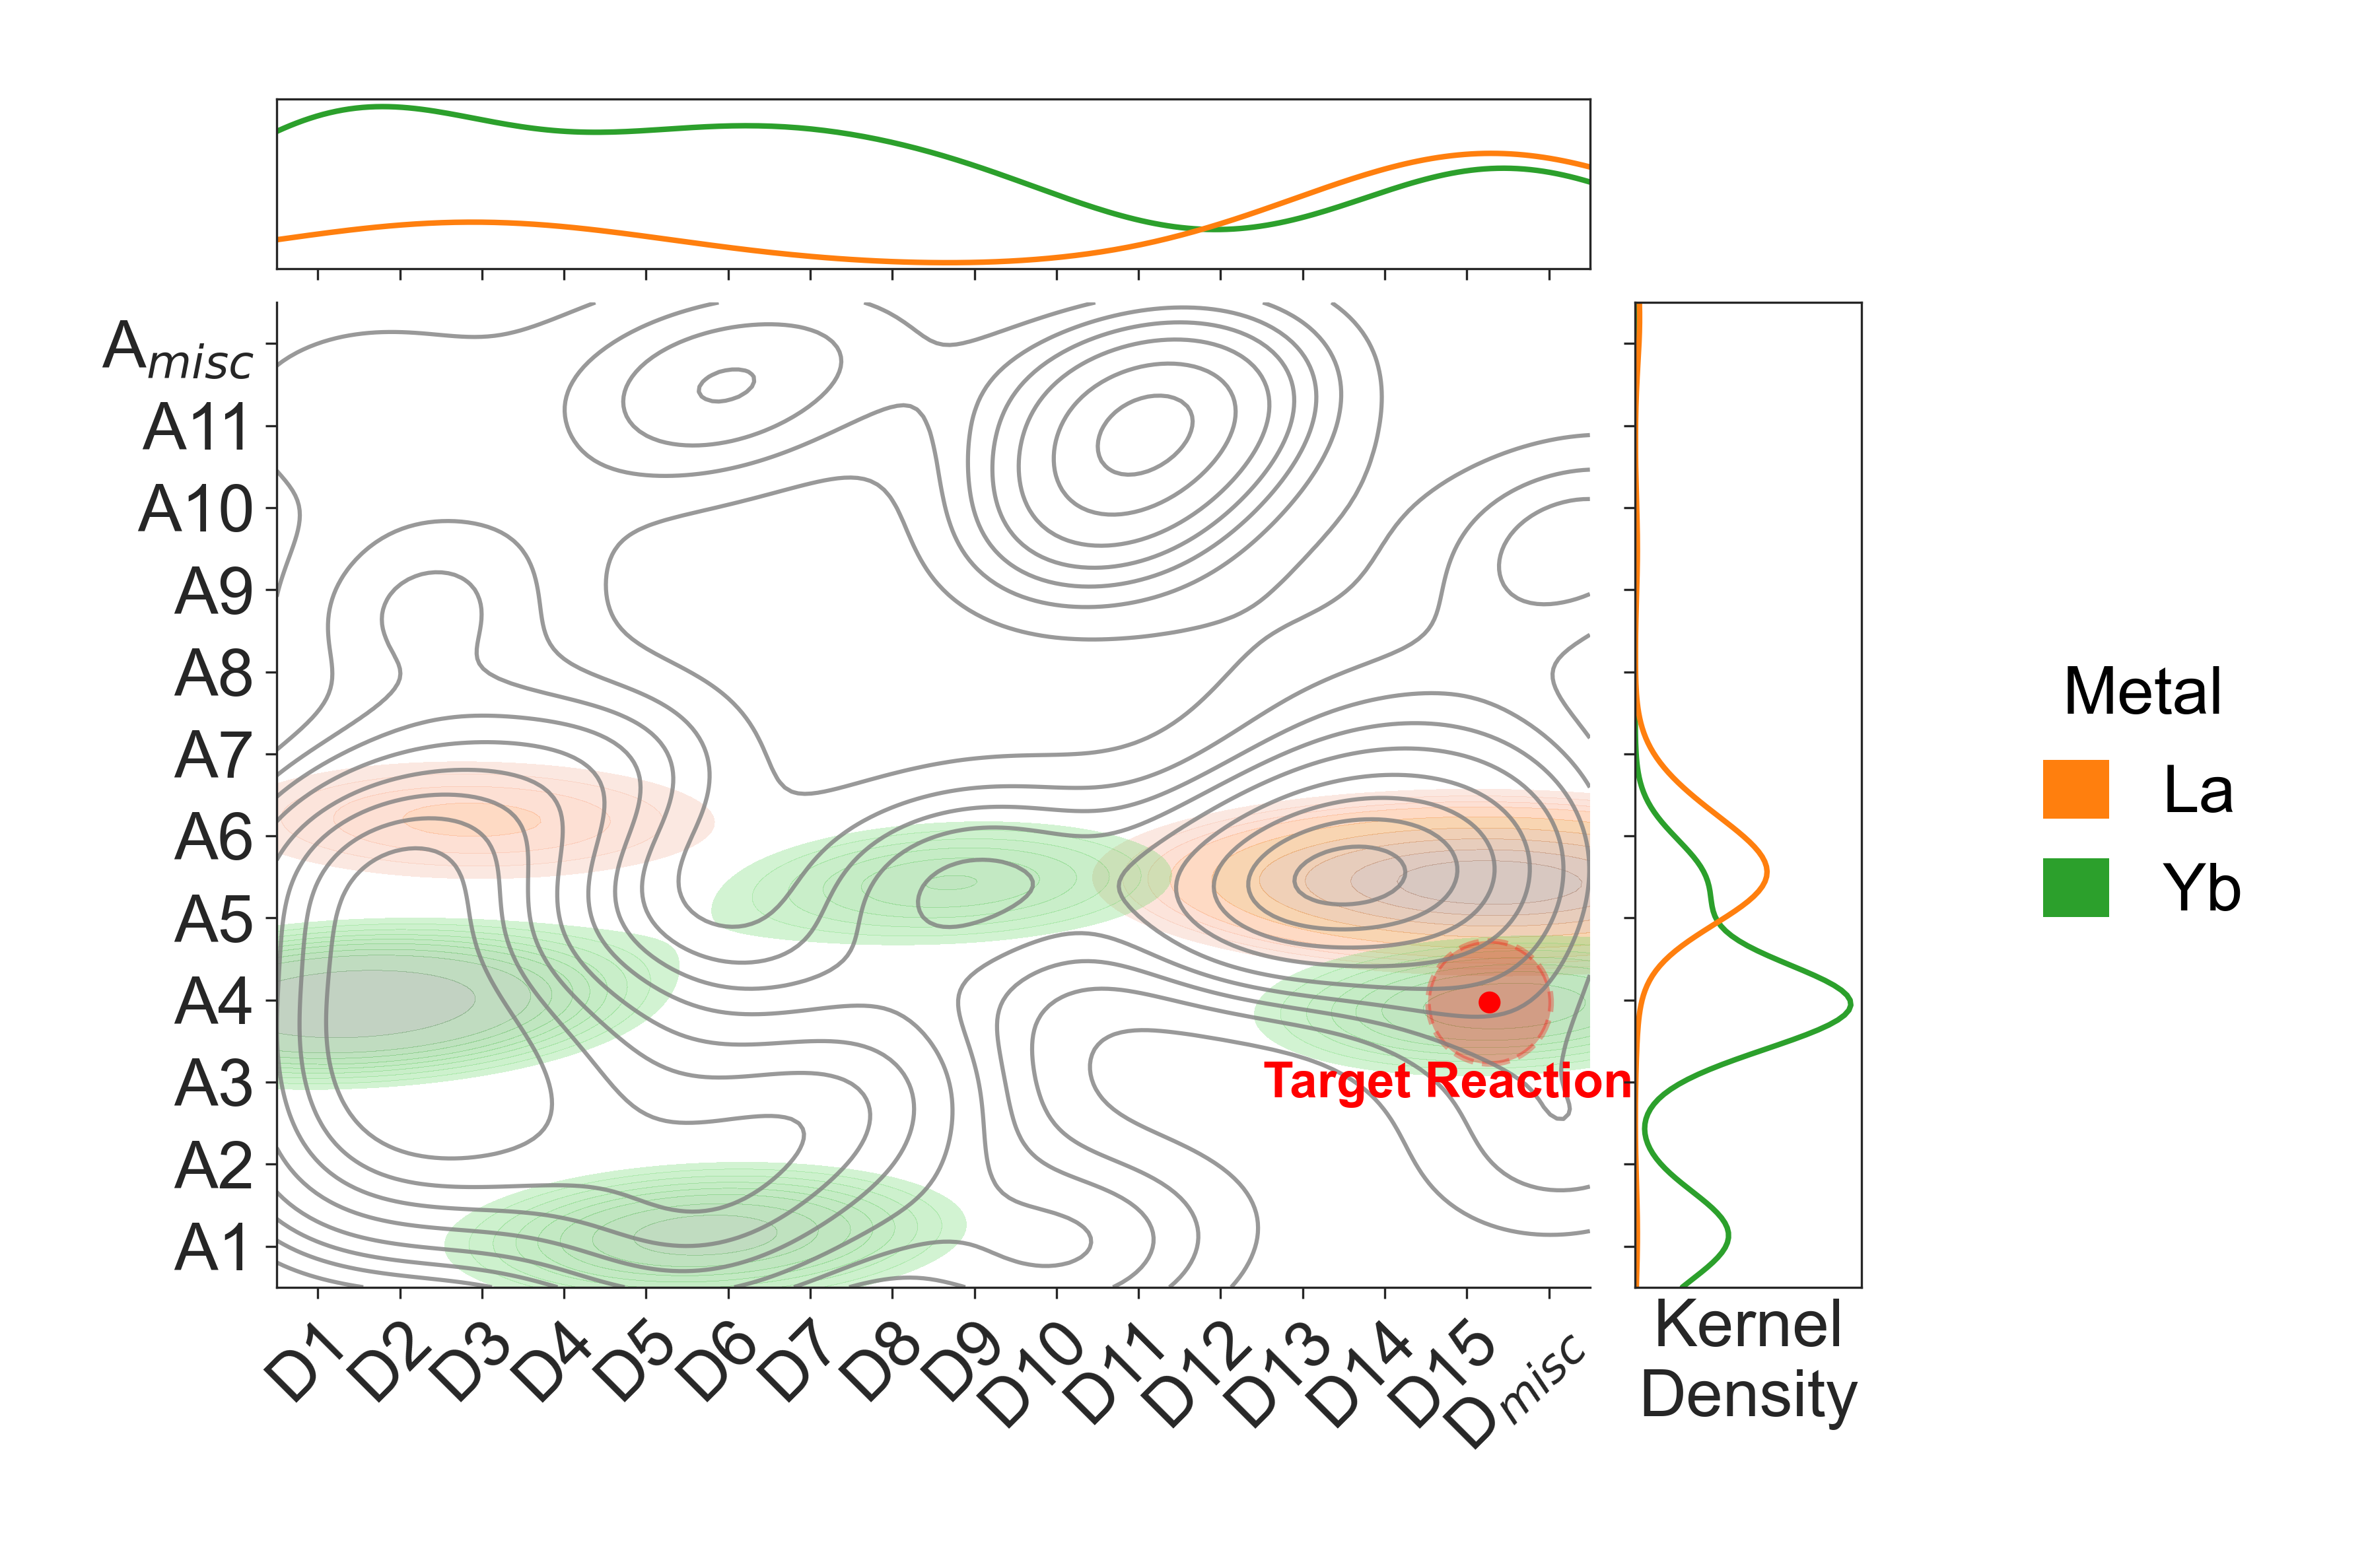

In [9]:
import matplotlib.patches as patches

g4 = build_overlap(
    background_data.loc[background_data["Metal"].isin(["La", "Yb"])],
    "Metal",
    background_data,
    thresh=0.32,
    palette=sns.color_palette()[1:],
)
sns.move_legend(
    g4.ax_joint,
    loc="center left",
    bbox_to_anchor=(1.3, 0.5),
    fontsize=24,
    title_fontsize=24,
)
rect_y = get_reactant_indice(
    "[CH3:23][c:19]1[n:18][n:17]([C:15](=[O:16])/[CH:14]=[CH:7]/[c:8]2[cH:9][cH:10][cH:11][cH:12][cH:13]2)[c:21]([CH3:22])[cH:20]1",
    acceptor_templates_mapping,
)
rect_x = get_reactant_indice(
    "[CH3:1][O:2][C:3](=[O:4])[CH2:5][SH:6]",
    donor_templates_mapping,
)
circle_small = patches.Circle(
    (rect_x, rect_y),
    0.1,
    facecolor="red",
    edgecolor="red",
    lw=2,  # 线宽
)  # 虚线
g4.ax_joint.add_patch(circle_small)
circle_big = patches.Circle(
    (rect_x, rect_y),
    0.75,
    facecolor="red",
    edgecolor="red",
    alpha=0.3,  # 设置透明度
    lw=2,  # 线宽
    linestyle="--",
)  # 虚线
g4.ax_joint.add_patch(circle_big)

g4.ax_joint.text(
    rect_x - 0.5,
    rect_y - 1,
    "Target Reaction",
    fontsize=18,
    color="red",
    ha="center",
    va="center",
    fontweight="bold",
)

b4 = pw.load_seaborngrid(g4, figsize=(8, 6))
b4